# Задача: создание модели нейронной сети для определения тональности комментариев

### Основные этапы реализации:

> Исследование и очистка данных

> Стандартизация данных в формат, пригодный для обработки нейросетью

> Определение структуры и слоев нейронной сети

> Обучение модели

> Тестирование модели и проверка метрик точности

> Подготовка к практическому применению модели

### Подключение первичных необходимых библиотек

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [20]:
pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Note: you may need to restart the kernel to use updated packages.


In [75]:
pip install pymorphy3

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install nltk

  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.7 MB/s  0:00:00
Using cached click-8.3.1-py3-none-any.whl (108 kB)

   ---------- ----------------------------- 1/4 [regex]
   ------------------------------ --------- 3/4 [nltk]
   ------------------------------ --------- 3/4 [nltk]
   ------------------------------ --------- 3/4 [nltk]
   ------------------------------ --------- 3/4 [nltk]
   ------------------------------ --------- 3/4 [nltk]
   ------------------------------ --------- 3/4 [nltk]
   ------------------------------ --------- 3/4 [nltk]
   ------------------------------ --------- 3/4 [nltk]
   ------------------------------ --------- 3/4 [nltk]
   ---------------------------------------- 4/4 [nltk]

Note: you may need to restart the kernel to use updated packa

In [71]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Загрузка комментариев и работа с датасетом

In [49]:
file_14k = os.path.join(os.path.expanduser("~"), "Desktop\ML2\Toxic_comments_ai\Data\comments.xlsx")
file_250k = os.path.join(os.path.expanduser("~"), "Desktop\ML2\Toxic_comments_ai\Data\dataset.txt")

# file_14k = r"D:\YupiterProjects4course\ML2\Toxic_comments_ai\Data\comments.xlsx"
# file_250k = r"D:\YupiterProjects4course\ML2\Toxic_comments_ai\Data\dataset.txt"

with open(file_14k, encoding = 'utf-8') as file:
    print("Успех")
with open(file_250k, encoding = 'utf-8') as file:
    print("Успех")

df = pd.read_excel(file_14k, skiprows=1)

Успех
Успех


In [50]:
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [52]:
df['toxic'] = df['toxic'].astype(int)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  14412 non-null  object
 1   toxic    14412 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 169.0+ KB


In [54]:
df.toxic.value_counts()

toxic
0    9586
1    4826
Name: count, dtype: int64

In [55]:
df.comment[14409]

'Посмотрел Утомленных солнцем 2. И оказалось, что это хороший фильм, такая высокобюджетная артхаусятина, к которой могут быть претензии только потому, что спиздили-распилили и вообще ТАК НЕ БЫВАЕТ. Ну нахуй этих критиков. Обзоры длиннее фильмов, петросянство хуже рашкокомедий, ебанутая ненависть и доебки по мелочам.\n'

In [56]:
df.comment[14411]

'До сих пор пересматриваю его видео. Орамбо кстати на своем канале пилит похожий контент, но качеством похуже, там же и Шуран не редко светится, храню хрупкую надежду что когда-то он вернется, такая годнота ведь.\n'

In [57]:
def create_df():
    data_list = []
    with open(file_250k, 'r', encoding = 'utf-8') as file:
        for idx, line in enumerate(file):
            parts = line.split(maxsplit=1)
            labels = parts[0].replace('__label__','')
            text = parts[1].strip()
            mask = [1 if "NORMAL" in labels else 0,
                    1 if "INSULT" in labels else 0,
                    1 if "THREAT" in labels else 0,
                    1 if "OBSCENITY" in labels else 0]
            data_list.append((text, *mask))
        return pd.DataFrame(data_list, columns=["comment", "normal", "insult", "threat", "obscenity"])

In [58]:
df2 = create_df()

In [59]:
df2

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0
...,...,...,...,...,...
248285,правильно всё по пять (5)...,1,0,0,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,0,1,0,0
248287,а у меня наверное рекорд в 1962 году в училище...,1,0,0,0
248288,спасибо всем большое),1,0,0,0


In [60]:
df2.normal.value_counts()

normal
1    203685
0     44605
Name: count, dtype: int64

In [61]:
df2.comment[1]

'я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином ( на пустыре) бежала кошка похожего окраса. может, я и ошиблась, но необычный окрас бросился в глаза.'

In [62]:
# df2.to_csv("comments_250k.csv", index=False, encoding='utf-8-sig')

### Очистка данных

In [63]:
df2

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0
...,...,...,...,...,...
248285,правильно всё по пять (5)...,1,0,0,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,0,1,0,0
248287,а у меня наверное рекорд в 1962 году в училище...,1,0,0,0
248288,спасибо всем большое),1,0,0,0


In [64]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248290 entries, 0 to 248289
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   comment    248290 non-null  object
 1   normal     248290 non-null  int64 
 2   insult     248290 non-null  int64 
 3   threat     248290 non-null  int64 
 4   obscenity  248290 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [65]:
# Перевод комментов в строчный вид
df2['comment'] = df2['comment'].str.lower()
# Удаление лишних пробелов по бокам и символы переноса строки
df2['comment'] = df2['comment'].str.strip()

In [66]:
df2

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0
...,...,...,...,...,...
248285,правильно всё по пять (5)...,1,0,0,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,0,1,0,0
248287,а у меня наверное рекорд в 1962 году в училище...,1,0,0,0
248288,спасибо всем большое),1,0,0,0


In [67]:
df2.comment[1]

'я сегодня проезжала по рабочей и между домами снитенко и гомолысовой магазином ( на пустыре) бежала кошка похожего окраса. может, я и ошиблась, но необычный окрас бросился в глаза.'

In [68]:
import re

def clean_text(text):
    # Удаление URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Удаление символов отлчных от ASCII
    text = re.sub('[^a-zA-Zа-яА-ЯёЁ]+', ' ', text)
    # Удаление пунктуации и спецсимволов
    text = re.sub(r'[^\w\s]', ' ', text)
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [69]:
df2['comment'] = df2['comment'].apply(clean_text)

In [70]:
df2.comment[248285]

'правильно всё по пять'

### Токенизация, удаление стоп-слов, лемматизация

In [76]:
import nltk
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords

# nltk.download('stopwords')
# nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [217]:
morph = MorphAnalyzer()
my_stop_words = ["такой", "это", "всё", "весь"]
stop_words = set(stopwords.words('russian'))
stop_words.update(my_stop_words)

def full_preprocess(text):  
    # Токенизация
    tokens = nltk.word_tokenize(text.lower())
    # Очистка
    words = [t.replace('ё', 'е') for t in tokens if t.isalpha()]
    # Лемматизация
    lemmas = [morph.parse(w)[0].normal_form for w in words]
    # Удаление стоп-слов
    filtered_lemmas = [l for l in lemmas if l not in stop_words]
    
    return filtered_lemmas

In [78]:
%%time
df2['comment'] = df2['comment'].apply(full_preprocess)

CPU times: total: 5min 34s
Wall time: 5min 36s


In [79]:
df2

,comment,normal,insult,threat,obscenity
0,"[скотина, сказать]",0,1,0,0
1,"[сегодня, проезжать, рабочий, дом, снитенко, г...",1,0,0,0
2,"[очередной, лохотрон, придумывать, очередной, ...",1,0,0,0
3,"[ретро, дежавю, сложно, понять, чужое, сердце,...",1,0,0,0
4,"[статус, агрогородок, получить]",1,0,0,0
...,...,...,...,...,...
248285,"[правильно, пять]",1,0,0,0
248286,"[ёбанный, нуба, заходить, сервер, ник, creepro...",0,1,0,0
248287,"[наверное, рекорд, год, училище, коренной, зуб...",1,0,0,0
248288,"[спасибо, большой]",1,0,0,0


In [81]:
df2.comment[248285]

['правильно', 'пять']

### Визуальный анализ

C:\Users\User\AppData\Local\Temp\ipykernel_6240\314579830.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='magma')


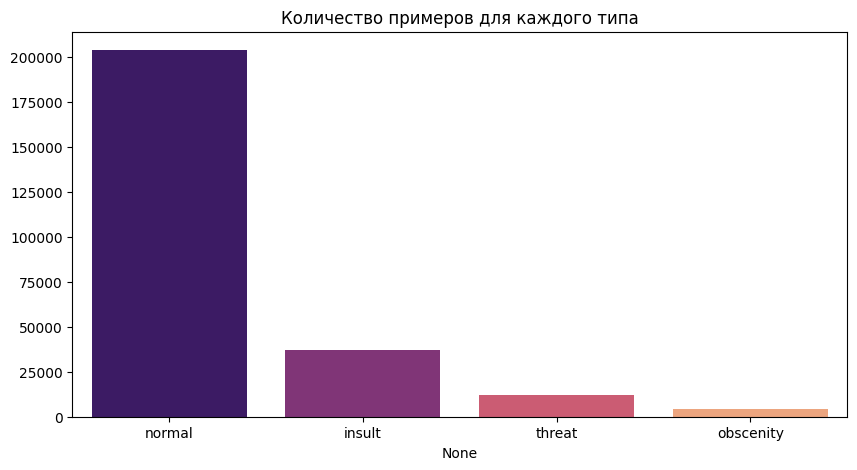

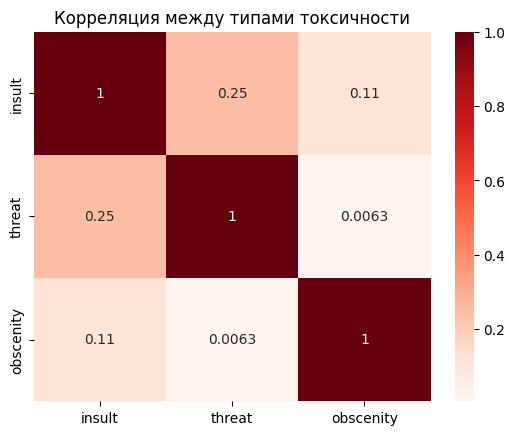

In [82]:
class_counts = df2[['normal', 'insult', 'threat', 'obscenity']].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='magma')
plt.title('Количество примеров для каждого типа')
plt.show()

sns.heatmap(df2[['insult', 'threat', 'obscenity']].corr(), annot=True, cmap='Reds')
plt.title('Корреляция между типами токсичности')
plt.show()

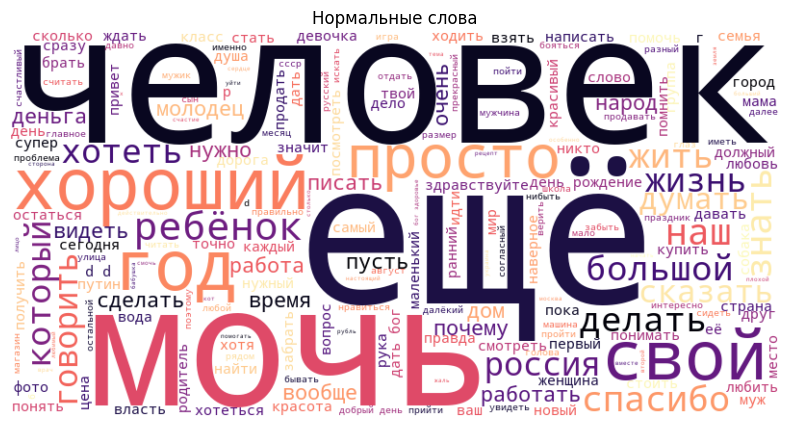

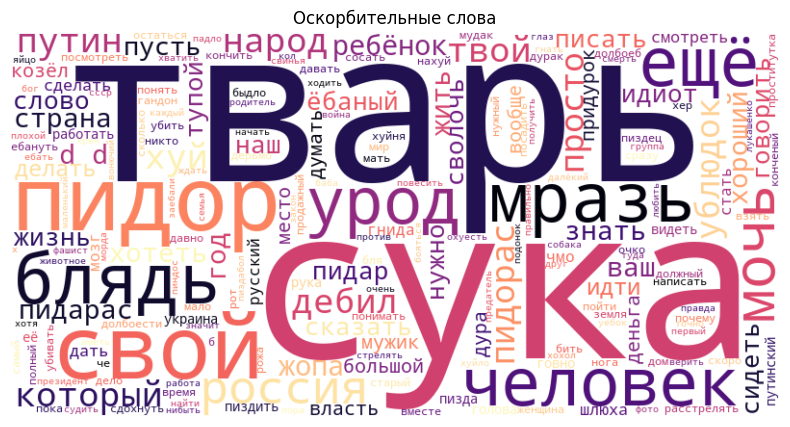

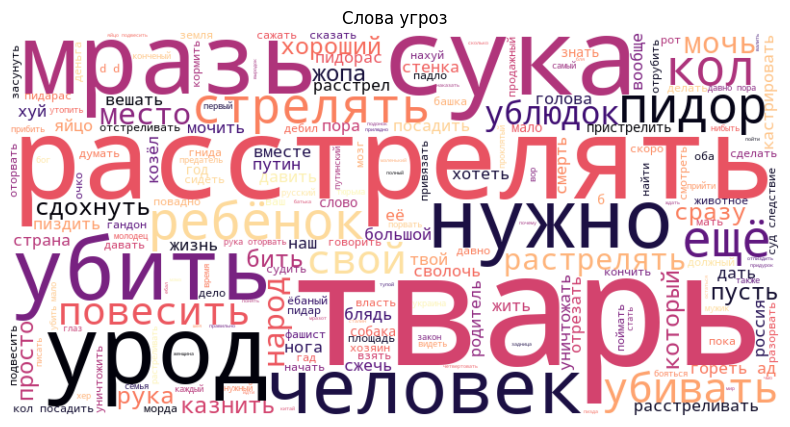

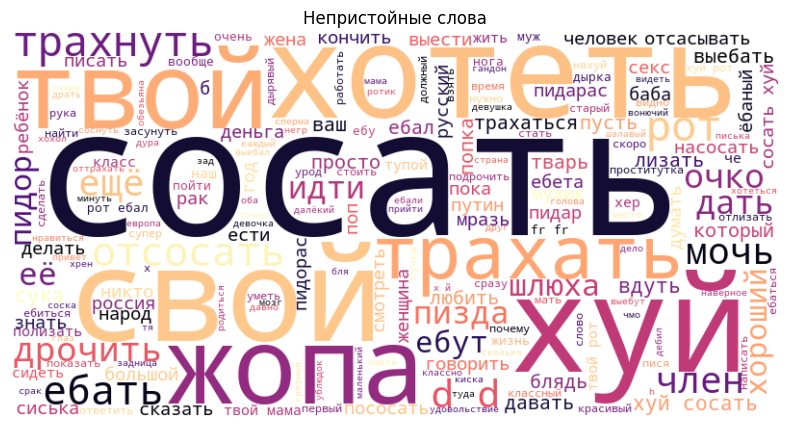

In [83]:
from wordcloud import WordCloud

def show_wordcloud(data: list, title):
    data = [" ".join(doc) for doc in data]
    text = " ".join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          colormap='magma').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_wordcloud(df2[df2['normal'] == 1]['comment'], "Нормальные слова")
show_wordcloud(df2[df2['insult'] == 1]['comment'], "Оскорбительные слова")
show_wordcloud(df2[df2['threat'] == 1]['comment'], "Слова угроз")
show_wordcloud(df2[df2['obscenity'] == 1]['comment'], "Непристойные слова")

In [84]:
# df2.to_csv("comments_250k_lemm.csv", index=False, encoding='utf-8-sig')

In [96]:
df2 = pd.read_csv(os.path.join(os.path.expanduser("~"), "Desktop\ML2\Toxic_comments_ai\Data\comments_250k_lemm.csv"))

# df2 = pd.read_csv(r"D:\YupiterProjects4course\ML2\Toxic_comments_ai\Data\comments_250k_lemm.csv")

#### Удаление 30% записей мажоритарного класса

In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248290 entries, 0 to 248289
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   comment    248290 non-null  object
 1   normal     248290 non-null  int64 
 2   insult     248290 non-null  int64 
 3   threat     248290 non-null  int64 
 4   obscenity  248290 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [100]:
only_normal = (df2['normal'] == 1) & (df2['insult'] == 0) & (df2['threat'] == 0) & (df2['obscenity'] == 0)

df_normal = df2[only_normal]
df_toxic = df2[~only_normal]

print(df2['normal'].value_counts())

normal
1    203685
0     44605
Name: count, dtype: int64


In [99]:
df_normal_reduced = df_normal.sample(frac=0.7, random_state=42)

# Соединяем обратно с токсичными комментариями
df_balanced = pd.concat([df_normal_reduced, df_toxic])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Новый размер датасета: {len(df_balanced)}")
print(df_balanced['normal'].value_counts())

Новый размер датасета: 187185
normal
1    142580
0     44605
Name: count, dtype: int64


In [102]:
df_balanced

,comment,normal,insult,threat,obscenity
0,"['егэ', 'говорить', 'развлекательный', 'меропр...",1,0,0,0
1,"['день', 'рождение', 'малыш']",1,0,0,0
2,"['вытащить', 'ящик', 'увидеть', 'знать', 'мочь...",1,0,0,0
3,"['г', 'путин', 'преступление', 'счесть', 'неви...",1,0,0,0
4,"['пристрелить', 'безумный', 'собака', 'тыпонят...",0,1,1,0
...,...,...,...,...,...
187180,"['наср', 'алла', 'беречься']",1,0,0,0
187181,"['мда', 'жить', 'страна', 'смерть', 'человек',...",1,0,0,0
187182,"['животное', 'вообще', 'хороший', 'lo', 'lo']",1,0,0,0
187183,"['хороший', 'трахнуть']",0,1,0,1


### Векторизация

In [221]:
def final_clean(text_list):
    if isinstance(text_list, str):
        import ast
        text_list = ast.literal_eval(text_list)
    return [str(w).replace("'", "") for w in text_list]

clean_comments = df_balanced['comment'].apply(final_clean)

In [222]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000 # Размер словаря
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(clean_comments)

sequences = tokenizer.texts_to_sequences(clean_comments)

MAX_LEN = 100 # Сколько слов остается в одном комментарии
X = pad_sequences(sequences, maxlen=MAX_LEN)

y = df_balanced[['normal', 'insult', 'threat', 'obscenity']].values

In [223]:
sequences

[[3684, 36, 12874, 2834, 3684, 1007, 15095],
 [9, 92, 308],
 [2768, 2437, 258, 15, 5, 3064, 136, 637, 2580],
 [157, 53, 1697, 7844, 4116, 1, 3065, 1125, 3294, 234, 959, 3633, 1, 157, 53],
 [1652, 4568, 132, 282, 1, 467, 198, 32, 346],
 [873, 14, 16, 67, 577, 347, 310, 310],
 [76, 15096, 10722],
 [7074, 2396, 171, 37, 46, 494, 7, 1014, 691, 9726],
 [729],
 [974, 515, 40],
 [126, 202, 4, 313, 3477, 4737, 711, 12, 874, 1251, 4, 711],
 [7845, 75, 7845],
 [75],
 [2347, 80, 947, 16596, 1233],
 [1251, 19],
 [131, 115, 438, 346, 314, 2554, 3810, 384, 1499, 464],
 [28, 6467, 21, 79, 2496],
 [2120, 104, 90, 5, 2369, 2610],
 [2891, 655, 5076, 360, 670, 4327, 52, 5836, 2581],
 [2892, 1291, 292, 1518],
 [7300, 185, 255, 1405, 16597, 362, 23, 80],
 [35, 79, 5199, 1, 4959, 1274, 1507],
 [90, 2323, 103, 8165, 5, 844, 852],
 [677, 677, 677, 7, 4569, 266, 433, 66, 6468, 350, 1644],
 [3098, 129, 6149, 278, 16598],
 [937, 6, 403, 784],
 [1063, 103, 101],
 [2],
 [61, 23, 770, 58],
 [57, 1379, 4, 20],
 [100

> Сохранение модели векторизации

In [297]:
import pickle

with open('tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

In [228]:
X[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   9,  92, 308])

In [229]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 1],
       [1, 0, 0, 0]], dtype=int64)

### Обучение рекурентной нейронной сети

> Разделение на тестовую и тренировочную часть

In [230]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [231]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(MAX_WORDS, 300, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [232]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               186880    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                      

In [233]:
history = model.fit(X_train, y_train,
              batch_size = 256,
              epochs = 5,
              validation_split=0.1)

Epoch 1/5
461/461 [==============================] - 100s 212ms/step - loss: 0.1902 - accuracy: 0.8869 - val_loss: 0.1123 - val_accuracy: 0.9345
Epoch 2/5
461/461 [==============================] - 98s 212ms/step - loss: 0.0928 - accuracy: 0.9442 - val_loss: 0.0933 - val_accuracy: 0.9412
Epoch 3/5
461/461 [==============================] - 98s 212ms/step - loss: 0.0689 - accuracy: 0.9550 - val_loss: 0.0987 - val_accuracy: 0.9390
Epoch 4/5
461/461 [==============================] - 98s 212ms/step - loss: 0.0566 - accuracy: 0.9611 - val_loss: 0.1158 - val_accuracy: 0.9404
Epoch 5/5
461/461 [==============================] - 97s 211ms/step - loss: 0.0480 - accuracy: 0.9648 - val_loss: 0.1261 - val_accuracy: 0.9355


> Проверка модели

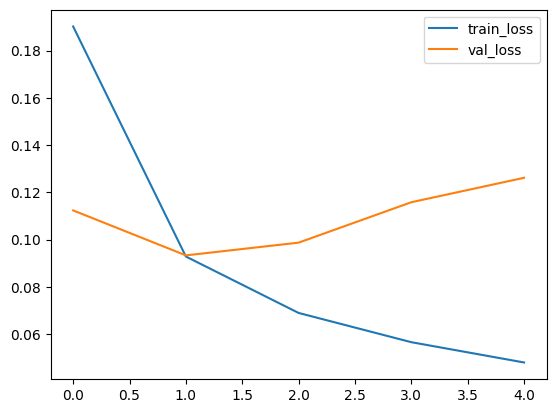

In [234]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [235]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test)

# Так как на выходе сигмоида (вероятности), превращаем их в 0 и 1
y_pred = (y_pred > 0.5).astype(int)

target_names = ['Нормальный', 'Оскорбление', 'Угроза', 'Неприрстойность']
print(classification_report(y_test, y_pred, target_names=target_names))

1755/1755 [==============================] - 28s 16ms/step
                 precision    recall  f1-score   support

     Нормальный       0.97      0.97      0.97     42661
    Оскорбление       0.90      0.87      0.88     11190
         Угроза       0.76      0.80      0.78      3546
Неприрстойность       0.83      0.74      0.78      1288

      micro avg       0.94      0.94      0.94     58685
      macro avg       0.87      0.85      0.85     58685
   weighted avg       0.94      0.94      0.94     58685
    samples avg       0.94      0.94      0.94     58685



C:\Users\User\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [294]:
def predict_toxicity(text):
    clean_text = full_preprocess(text) 
    print(f"Леммы: {clean_text}")
    
    seq = tokenizer.texts_to_sequences([clean_text]) 
    print(f"Индексы: {seq}")

    padded = pad_sequences(seq, maxlen=MAX_LEN)

    pred = model.predict(padded)[0]
    print(pred)
    
    results = dict(zip(target_names, pred))
    print(f"\nАнализ фразы: '{text}'")
    for label, prob in results.items():
        print(f"- {label}: {prob:.2%}")

In [295]:
predict_toxicity("Какашка")

Леммы: ['какашка']
Индексы: [[11421]]
1/1 [==============================] - 0s 16ms/step
[0.45037314 0.45853606 0.05600947 0.09767973]

Анализ фразы: 'Какашка'
- Нормальный: 45.04%
- Оскорбление: 45.85%
- Угроза: 5.60%
- Неприрстойность: 9.77%


In [296]:
model.save('lstm_model.h5')

C:\Users\User\anaconda3\envs\tensorflow\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
